### This is SA-GA network aligner program, and implemented by Elham Mahdipour that is Ph.D. Candidate of Artificial Intelligence at Yazd University, Yazd, Iran.  All copyright reserved by the author.
This program uploads on Github for available on Bioinformatics Journal reviewers.
2020/02/28

You can run the program from first to end and see all the results, but since the population generation process can take a time depended on the node numbers of networks, you can use the populations stored in each program. We saved the populations as the pair of related species that you can see in the input folder and load them on program, such as "mm-sc-pop.pickle". Therefore, you must run follow steps:
1) Run all cells in "Load Graphs", "Swap Graphs", "Define Target Graph",and "Compute Score for create similarity matrix" sections.
2) If you will use saved population, please upload related pickle on root of jupyter notebook, then go "load population" cell and run them; else, please run "multi tasking for initial population", "multi processing for speed up", and "Initialization such as MeAlign" cells. 
3) Run all remains cells to create results. 

# Load Graphs 

In [1]:
import pickle
# write name of species for open such as 'sc-sc-weighted.pickle'
with open('mm-mm-weighted.pickle', 'rb') as f:
    mmlist = pickle.load(f)

In [2]:
# write name of species for open such as 'ce-ce-weighted.pickle'
with open('sc-sc-weighted.pickle', 'rb') as f:
    sclist = pickle.load(f)

In [3]:
import networkx as nx
G1=nx.Graph()
for i in range(len(mmlist)):
    if G1.has_node(mmlist[i][0])==False:
        G1.add_node(mmlist[i][0])
    if G1.has_node(mmlist[i][1])==False:
        G1.add_node(mmlist[i][1])
    G1.add_edge(mmlist[i][0],mmlist[i][1],weight=mmlist[i][2])
G1

In [4]:
G2=nx.Graph()
for i in range(len(sclist)):
    if G2.has_node(sclist[i][0])==False:
        G2.add_node(sclist[i][0])
    if G2.has_node(sclist[i][1])==False:
        G2.add_node(sclist[i][1])
    G2.add_edge(sclist[i][0],sclist[i][1],weight=sclist[i][2])
G2

# Swap graphs if len G1 > len G2

In [5]:
### Check and Swap if G1 > G2 ###
if len(G1)>len(G2):
    temp=G1
    G1=G2
    G2=temp

In [6]:
ed1=G1.edges()

In [7]:
nd1=G1.nodes()

In [8]:
ed2=G2.edges()

In [9]:
nd2=G2.nodes()

In [10]:
el1=list(ed1)
el2=list(ed2)

In [11]:
nd1=list(nd1)
nd2=list(nd2)

In [12]:
degG1 = [val for (node, val) in G1.degree()]


In [13]:
degG2 = [val for (node, val) in G2.degree()]

# Define Target Graph

In [14]:
G_target_na=nx.read_weighted_edgelist('mm-sc.evals')
G_target_na 

In [15]:
gtnode=list(G_target_na.nodes())
g_t_node=[]
for i in range(len(gtnode)):
    if (G1.has_node(gtnode[i])==False and G2.has_node(gtnode[i])==False):
        continue
    else:
        g_t_node.append(gtnode[i])

In [16]:
G_target=nx.Graph()
for i in range(len(g_t_node)):
    for j in range(len(g_t_node)):
        if G_target_na.has_node(g_t_node[i])==False:
            G_target.add_node(g_t_node[i])
        if G_target_na.has_node(g_t_node[j])==False:
            G_target.add_node(g_t_node[j])
        if G_target_na.has_edge(g_t_node[i],g_t_node[j]):
            a=list(G_target_na.get_edge_data(g_t_node[i],g_t_node[j]).values())            
            G_target.add_edge(g_t_node[i],g_t_node[j],weight=a[0])
G_target_na=G_target
G_target_na

# Compute Score for create similarity matrix

In [17]:
def deg_Diff(G1,G2):
    Degree_Difference=np.zeros((len(G1),len(G2)))
    for i in range(len(G1)):
        for j in range(len(G2)):
            Degree_Difference[i][j]=abs(degG1[i]-degG2[j])/max(degG1[i],degG2[j])
    return Degree_Difference

In [18]:
def score_pageRank(X):
    a=nx.pagerank(X)
    return a

In [19]:
def coefficient_pagerank(x,y):  #x is G1, y is G2
   # print(len(x))
    p1=score_pageRank(x)
    b=p1.values()
    pr1=list(b)
    p2=score_pageRank(y)
    c=p2.values()
    pr2=list(c)
    pr=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            #print(pr1[i],pr2[j])
            pr[i][j]=abs(pr1[i]-pr2[j])/max(pr1[i],pr2[j])   #minimum pr is maximum similarity of topology 
    return pr

In [20]:
def coefficient_edges(index_node, G, GraphNumber):
    if GraphNumber==1:
        sum_edge=0        
        for i in G.neighbors(nd1[index_node]):                       
            sum_edge=sum_edge+degG1[nd1.index(i)]
        #print(sum_edge)
        temp=(degG1[index_node]-1) if degG1[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG1[index_node]*temp)
    else:
        sum_edge=0        
        for i in G.neighbors(nd2[index_node]):                       
            sum_edge=sum_edge+degG2[nd2.index(i)]
        #print(sum_edge)
        temp=(degG2[index_node]-1) if degG2[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG2[index_node]*temp)
    return coeff_node
    

In [21]:
def compute_Ea(G1,G2):
    Ea_G1=np.zeros(len(G1))
    Ea_G2=np.zeros(len(G2))
    for i in range(len(G1)):
        Ea_G1[i]=coefficient_edges(i, G1, 1)
    for j in range(len(G2)):
        Ea_G2[j]=coefficient_edges(j,G2,2)
    ea=[Ea_G1, Ea_G2]
    return(ea)

In [22]:
# compute relative clustering coefficient difference between node a (in G1) and node b (in G2)
def CD(G1, G2):
    cd=np.zeros((len(G1),len(G2)))
    EA=compute_Ea(G1,G2)
    #print(EA[0])      #Ea for G1
    #print("===================")
    #print(EA[1])      #Ea for G2
    for i in range(len(G1)):
        for j in range(len(G2)):
            cd[i,j]=abs(EA[0][i]-EA[1][j])/max(EA[0][i],EA[1][j])
    return cd

In [23]:
def sequence_score(x,y):
    seq=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            q1=G_target_na.get_edge_data(str(nd1[i]),str(nd2[j]))
            if q1==None:
                c=0
            else:
                c=list(q1.values())
                c=c[0]
            seq[i][j]=c    
            
    return seq

In [24]:
def compute_score(G1,G2):
    coeff_pr=coefficient_pagerank(G1,G2)
    dd=deg_Diff(G1,G2)
    cd=CD(G1,G2)
    seq_sc=sequence_score(G1,G2)
    
    alpha=0.1
    betta=0.2
    gamma=0.2
    zetta=1-alpha-betta-gamma
    s=alpha*(1-coeff_pr)+betta*(1-dd)+gamma*(1-cd)+zetta*seq_sc
    return s

In [25]:
# m is similarity matrix score (SIM)
import numpy as np
m=compute_score(G1,G2)
n=m

# multi tasking for initial population

In [26]:
def task1(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation):
    print('task1')
    for z1 in range(int(len_G1/3)):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])
  

In [27]:
def task2(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation):
    print('task2')
    for z1 in range(int(len_G1/3),int(2*len_G1/3)):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])
    

In [28]:
def task3(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation):
    print('task3')
    for z1 in range(int(2*len_G1/3),len_G1):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])

# multi processing for speed up

In [29]:
def fun_rand_permute(len_G1, base_permute, rand_permutation):
    for k in range(len_G1):
        rand_permutation[k]=random.sample(base_permute,len_G1)
    #print(rand_permutation)

# Initialization such as MeAlign

In [30]:
import random
import threading

len_pop=300
len_G1=len(G1)
len_G2=len(G2)
similarity_score_matrix=np.zeros((len_G1,len_G1))
sim_score_matrix=np.zeros((len_G1,len_G1))
pop=np.zeros((len_pop,len_G1,2))
index_score=np.zeros(len_G1)
rand_permutation=np.zeros((len_G1,len_G1))
base_permute = [j for  j in range(0, len_G2)]

for i in range(len_pop):  
    print('wait')
    if i>0:
        do_not_permute = set(base_permute)-set(index_score)
        #print(do_not_permute)
        #print(len(base_permute))
        base_permute.extend(do_not_permute)
        #print(len(do_not_permute))
        #print(len(base_permute))
        #print(base_permute)
    t = threading.Thread(target=fun_rand_permute, args=(len_G1,base_permute, rand_permutation,))
    t.start() 
    t.join()
    #print(rand_permutation)
               
    print('in for loop')
    
    t1 = threading.Thread(target=task1, args=(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation,)) 
    t2 = threading.Thread(target=task2, args=(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation,))
    t3 = threading.Thread(target=task3, args=(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation,))
    # starting thread 1 
    t1.start() 
    # starting thread 2 
    t2.start() 
    # starting thread 3 
    t3.start() 
    # wait until thread 1 is completely executed 
    t1.join() 
    # wait until thread 2 is completely executed 
    t2.join() 
    # wait until thread 3 is completely executed 
    t3.join()
    # both threads completely executed 
    print("Done!, i=",i) 
    
pop

wait
in for loop
task1
task2
task3
Done!, i= 0
wait
in for loop
task1
task2
task3
Done!, i= 1
wait
in for loop
task1
task2
task3
Done!, i= 2
wait
in for loop
task1
task2
task3
Done!, i= 3
wait
in for loop
task1
task2
task3
Done!, i= 4
wait
in for loop
task1
task2
task3
Done!, i= 5
wait
in for loop
task1
task2
task3
Done!, i= 6
wait
in for loop
task1
task2
task3
Done!, i= 7
wait
in for loop
task1
task2
task3
Done!, i= 8
wait
in for loop
task1
task2
task3
Done!, i= 9
wait
in for loop
task1task2

task3
Done!, i= 10
wait
in for loop
task1
task2
task3
Done!, i= 11
wait
in for loop
task1
task2
task3
Done!, i= 12
wait
in for loop
task1
task2
task3
Done!, i= 13
wait
in for loop
task1
task2
task3
Done!, i= 14
wait
in for loop
task1
task2
task3
Done!, i= 15
wait
in for loop
task1
task2
task3
Done!, i= 16
wait
in for loop
task1
task2
task3
Done!, i= 17
wait
in for loop
task1
task2
task3
Done!, i= 18
wait
in for loop
task1
task2
task3
Done!, i= 19
wait
in for loop
task1task2

task3
Done!, i= 20
wa

Done!, i= 169
wait
in for loop
task1
task2
task3
Done!, i= 170
wait
in for loop
task1
task2
task3
Done!, i= 171
wait
in for loop
task1
task2
task3
Done!, i= 172
wait
in for loop
task1
task2
task3
Done!, i= 173
wait
in for loop
task1
task2
task3
Done!, i= 174
wait
in for loop
task1
task2
task3
Done!, i= 175
wait
in for loop
task1
task2
task3
Done!, i= 176
wait
in for loop
task1
task2
task3
Done!, i= 177
wait
in for loop
task1
task2
task3
Done!, i= 178
wait
in for loop
task1
task2
task3
Done!, i= 179
wait
in for loop
task1
task2
task3
Done!, i= 180
wait
in for loop
task1
task2
task3
Done!, i= 181
wait
in for loop
task1
task2
task3
Done!, i= 182
wait
in for loop
task1
task2
task3
Done!, i= 183
wait
in for loop
task1task2

task3
Done!, i= 184
wait
in for loop
task1
task2
task3
Done!, i= 185
wait
in for loop
task1
task2
task3
Done!, i= 186
wait
in for loop
task1
task2
task3
Done!, i= 187
wait
in for loop
task1
task2
task3
Done!, i= 188
wait
in for loop
task1
task2task3

Done!, i= 189
wait
i

array([[[0.000e+00, 1.583e+03],
        [1.000e+00, 2.154e+03],
        [2.000e+00, 2.825e+03],
        ...,
        [6.200e+02, 5.050e+02],
        [6.210e+02, 2.543e+03],
        [6.220e+02, 1.530e+02]],

       [[0.000e+00, 9.110e+02],
        [1.000e+00, 1.293e+03],
        [2.000e+00, 2.372e+03],
        ...,
        [6.200e+02, 5.050e+02],
        [6.210e+02, 2.917e+03],
        [6.220e+02, 2.619e+03]],

       [[0.000e+00, 2.456e+03],
        [1.000e+00, 5.020e+02],
        [2.000e+00, 2.677e+03],
        ...,
        [6.200e+02, 9.680e+02],
        [6.210e+02, 1.623e+03],
        [6.220e+02, 1.530e+02]],

       ...,

       [[0.000e+00, 2.678e+03],
        [1.000e+00, 1.466e+03],
        [2.000e+00, 2.886e+03],
        ...,
        [6.200e+02, 4.830e+02],
        [6.210e+02, 1.942e+03],
        [6.220e+02, 2.046e+03]],

       [[0.000e+00, 1.059e+03],
        [1.000e+00, 1.557e+03],
        [2.000e+00, 1.964e+03],
        ...,
        [6.200e+02, 2.650e+03],
        [6.210e+02

# save population

In [31]:
import pickle
with open('mm-sc-base_permute.pickle', 'wb') as f:
    pickle.dump(base_permute, f)

In [32]:
import pickle
with open('mm-sc-pop.pickle', 'wb') as f:
    pickle.dump(pop, f)

## You can load population if there is save population such as 'ce-sc-pop.pickle'

# load population

In [26]:
import pickle
with open('mm-sc-base_permute.pickle', 'rb') as f:
    base_permute = pickle.load(f)

In [27]:
with open('mm-sc-pop.pickle', 'rb') as f:
    pop = pickle.load(f)

# compute measure edge correctness, ics, nc and s3

In [28]:
# ec function
def ec_func(pop1,pop2):
    a=list(G1.neighbors(pop1));
    b=list(G2.neighbors(pop2));
    for i in range(len(a)):
        for j in range(len(b)):
           # print(pop1,a[i],G1.has_edge(pop1,a[i]))
           # print(pop2,b[j],G2.has_edge(pop2,b[j]))
           # print(G_target_na.has_edge(a[i],b[j]))
            if(G1.has_edge(pop1,a[i]) and G2.has_edge(pop2,b[j]) and G_target_na.has_edge(a[i],b[j])):
                return True
    return False 

In [29]:
def induced_function_for_initialpop(sub_pop):
    num_induced=0
    sub_g2=list(set([sub_pop[i][1] for i in range(len(G1))]))
    for i in range(len(sub_g2)):
        for j in range(i,len(sub_g2)):
            if G2.has_edge(nd2[int(sub_g2[i])], nd2[int(sub_g2[j])]):
                num_induced=num_induced+1
    return num_induced

In [30]:
len_pop=len(pop)
score_ec=np.zeros(len_pop)
score_ics=np.zeros(len_pop)
score_s3=np.zeros(len_pop)
score_nc=np.zeros(len_pop)
score_ncorectness=np.zeros(len_pop)
num_seq=np.zeros(len_pop)

p=pop 
len_G1=len(G1)
map_items=[] 


for i in range(len(p)):
    ea=0
    nc=0
    sub_pop=p[i]
    sub_g2=list(set([sub_pop[i][1] for i in range(len(G1))]))
    num_induced=induced_function_for_initialpop(sub_pop) 
    #print("number induced for i=",i," is: ",num_induced)
    
    for j in range(len_G1):                          
         if G_target_na.has_edge(nd1[int(p[i][j][0])],nd2[int(p[i][j][1])]):
            num_seq[i]+=1  # create sequence matrix 
            map_items.append([nd1[int(p[i][j][0])],nd2[int(p[i][j][1])]])
            if (ec_func(nd1[int(p[i][j][0])],nd2[int(p[i][j][1])])):
                ea=ea+1                
            
            nc=nc+2
                 
    score_ec[i]=(ea/G1.number_of_edges())*100
    score_ics[i]=(ea/num_induced)*100
    score_s3[i]=(ea/(G1.number_of_edges()+num_induced-ea))*100
    score_nc[i]=(nc/(G1.number_of_nodes()))*100 # node coverage    
    score_ncorectness[i]=(nc/G_target_na.number_of_nodes())*100

print('ec')
print(score_ec)
print('ics')
print(score_ics)
print('s3')
print(score_s3)
print('node coverage: ',score_nc)
print('node correctness',score_ncorectness)

ec
[8.57954545 9.65909091 8.69318182 8.35227273 7.89772727 7.78409091
 7.44318182 8.18181818 8.06818182 8.40909091 8.40909091 8.57954545
 8.40909091 8.29545455 8.97727273 8.63636364 8.18181818 7.95454545
 8.40909091 8.06818182 8.69318182 9.31818182 7.89772727 8.52272727
 8.18181818 8.18181818 8.06818182 7.95454545 8.01136364 8.18181818
 7.89772727 8.23863636 8.35227273 8.46590909 8.97727273 8.52272727
 8.57954545 8.63636364 8.57954545 7.55681818 8.06818182 8.23863636
 8.40909091 7.72727273 8.57954545 7.84090909 8.18181818 8.75
 8.80681818 8.40909091 8.125      7.78409091 8.35227273 8.92045455
 8.75       8.46590909 7.95454545 7.78409091 7.78409091 8.52272727
 7.67045455 8.18181818 8.40909091 7.72727273 8.86363636 8.57954545
 7.89772727 9.375      8.63636364 8.52272727 8.40909091 8.52272727
 8.35227273 8.125      7.55681818 8.40909091 7.95454545 8.86363636
 8.63636364 8.40909091 8.35227273 8.23863636 7.89772727 7.89772727
 8.52272727 7.78409091 8.75       8.57954545 8.92045455 8.6363636

## number of matched sequences 

In [31]:
num_seq

array([151., 170., 153., 147., 139., 137., 131., 144., 142., 148., 148.,
       151., 148., 146., 158., 152., 144., 140., 148., 142., 153., 164.,
       139., 150., 144., 144., 142., 140., 141., 144., 139., 145., 147.,
       149., 158., 150., 151., 152., 151., 133., 142., 145., 148., 136.,
       151., 138., 144., 154., 155., 148., 143., 137., 147., 157., 154.,
       149., 140., 137., 137., 150., 135., 144., 148., 136., 156., 151.,
       139., 165., 152., 150., 148., 150., 147., 143., 133., 148., 140.,
       156., 152., 148., 147., 145., 139., 139., 150., 137., 154., 151.,
       157., 152., 151., 132., 152., 153., 157., 150., 145., 152., 141.,
       141., 143., 143., 152., 148., 134., 140., 160., 147., 149., 147.,
       137., 149., 146., 147., 141., 146., 134., 148., 150., 150., 149.,
       157., 148., 145., 151., 144., 147., 150., 143., 142., 140., 139.,
       152., 150., 148., 150., 142., 148., 147., 154., 155., 139., 149.,
       151., 146., 147., 135., 145., 142., 151., 15

## compute topology score

In [32]:
#compute Final Score
tscore=np.zeros(len_pop)
for i in range(len(p)):
    tscore[i]=(0.25*(score_ec[i]/G1.number_of_edges())+0.25*(score_s3[i]/(G1.number_of_edges()+score_ics[i]-score_ec[i]))+0.25*(score_ics[i]/2*G1.number_of_edges())+0.25*(score_nc[i]/(G1.number_of_nodes()+G2.number_of_nodes())))
print(tscore)

[3545.36155659 3681.10688069 3379.52214007 3340.91300591 3281.11959004
 3196.18604971 3223.71715176 3543.628018   3362.75944329 3662.54614915
 3452.81412995 3142.86113851 3416.58317007 3476.19437781 3757.84206367
 3275.2244054  3424.86871214 2883.89882981 3071.70202778 3264.37159977
 3674.67658259 3921.74352054 2948.89471224 3360.49278982 3355.93604486
 2933.33713548 3260.96411741 3283.58582496 3204.54920808 3187.12656298
 3298.81708818 3305.70334393 3455.13213    3670.7766691  3725.62051465
 3251.23550847 3460.42069191 3243.45698848 3253.67687613 3022.7308112
 3184.50938316 3190.00385165 3848.70374474 3320.75835533 3328.66132803
 3117.0467923  3279.50694043 3439.59800677 3326.83338077 3486.08532295
 3193.91243178 3165.97003707 3300.00391135 3746.20810434 3263.97325314
 3425.2913286  3422.22596903 3283.22806124 3050.61092781 3244.84173889
 3030.61583379 3310.34866513 3233.37036506 3087.72291706 3456.19750289
 3496.84613368 3316.70653313 4134.40078787 3634.78667382 3594.7752535
 3467.52

# Compute Topology and Sequence score

In [33]:
# Final Score
score=np.zeros(len_pop)
alpha=0.5
for i in range (len(p)):
    score[i]=alpha*tscore[i]+(1-alpha)*num_seq[i]   
score

array([1848.18077829, 1925.55344034, 1766.26107004, 1743.95650295,
       1710.05979502, 1666.59302485, 1677.35857588, 1843.814009  ,
       1752.37972165, 1905.27307457, 1800.40706498, 1646.93056925,
       1782.29158503, 1811.0971889 , 1957.92103184, 1713.6122027 ,
       1784.43435607, 1511.9494149 , 1609.85101389, 1703.18579989,
       1913.83829129, 2042.87176027, 1543.94735612, 1755.24639491,
       1749.96802243, 1538.66856774, 1701.48205871, 1711.79291248,
       1672.77460404, 1665.56328149, 1718.90854409, 1725.35167196,
       1801.066065  , 1909.88833455, 1941.81025732, 1700.61775424,
       1805.71034596, 1697.72849424, 1702.33843806, 1577.8654056 ,
       1663.25469158, 1667.50192583, 1998.35187237, 1728.37917766,
       1739.83066402, 1627.52339615, 1711.75347022, 1796.79900339,
       1740.91669038, 1817.04266148, 1668.45621589, 1651.48501854,
       1723.50195568, 1951.60405217, 1708.98662657, 1787.1456643 ,
       1781.11298452, 1710.11403062, 1593.8054639 , 1697.42086

## Define function for fitness and compute final score

In [34]:
def induced_function_for_pop(wpop):
    counter_induced=0
    subg=list(set([wpop[i][1] for i in range(len_G1)]))
    for i in range(len(subg)):
        for j in range(i,len(subg)):
            if G2.has_edge(nd2[int(subg[i])], nd2[int(subg[j])]):
                counter_induced=counter_induced+1
    #print("con: ",counter_induced)
    return counter_induced

In [35]:
def Fitness(wpop,counter_induced):
    ec_temp=0
    nc_temp=0
    num_seq_temp=0
    score_ncorectness=0
    
  
    for j in range(len_G1):        
        x1=int(wpop[j][0])
        x2=int(wpop[j][1])
        if G_target_na.has_edge(nd1[x1],nd2[x2]):
            num_seq_temp+=1 
            if (ec_func(nd1[x1],nd2[x2])):
                ec_temp=ec_temp+1                
            nc_temp=nc_temp+2
                 
    score_ec_temp=(ec_temp/G1.number_of_edges())*100
    score_ics_temp=(ec_temp/counter_induced)*100
    score_s3_temp=(ec_temp/(G1.number_of_edges()+counter_induced-ec_temp))*100
    score_nc_temp=(nc_temp/G1.number_of_nodes())*100 # node coverage 
    score_ncorectness=(nc/G_target_na.number_of_nodes())*100
    
    
     # local measures
    pre=ec_temp/G_target_na.number_of_edges()*100
    rec=ec_temp/len(wpop)*100
    fsc=2*((pre*rec)/(pre+rec))
    
    if (GbestFlag==True):
        print('ec')
        print(score_ec_temp)
        print('ics')
        print(score_ics_temp)
        print('s3')
        print(score_s3_temp)
        print('node coverage: ',score_nc_temp)
        print('node correctness: ',score_ncorectness)
        print('num_seq',num_seq_temp)
        print('precision: ',pre)
        print('Recall: ',rec)
        print('F-score: ',fsc)

    alpha=0.5
    tscore_temp=(0.25*(score_ec_temp/G1.number_of_edges())+0.25*(score_s3_temp/(G1.number_of_edges()+score_ics_temp-score_ec_temp))+0.25*(score_ics_temp/2*G1.number_of_edges())+0.25*(score_nc_temp/(G1.number_of_nodes()+G2.number_of_nodes())))
    score_temp=alpha*tscore_temp+(1-alpha)*num_seq_temp
    print('score:',score_temp)
    return score_temp,pre,rec,fsc


# SA-GA method

In [36]:
def crossover(index,r1): 
    tp=[]
    
    for i in range(len_pop-1):            
            if (r1>0):
                alpha=random.random()
                P_crossover=(pop[i][dim]*r1-r1*2*alpha)/1000
                print(P_crossover)
                tp.append(pop[i][0:len_G1])                
                for j in range(int(P_crossover)):
                    x=random.randint(0,len_G1-1)
                    #print('x',x)
                    y=np.argmax(m[x])
                    #print('y',y,'index',index,len(tp))
                    #print(tp[index])
                    #print(nd1[int(tp[index][x][0])],nd2[y])
                    #print('crossover ===============',G_target_na.has_edge(nd1[int(tp[index][x][0])],nd2[y]))
                    if (G_target_na.has_edge(nd1[int(tp[index][x][0])],nd2[y])):                                                    
                        tp[index][x][1]=y
                        fit,pre,rec,fsc=Fitness(tp[index],counter_induced)
                        tp[index].append(fit)
                        if(fit>pop[i][dim]):
                            pool.append(tp)
                            print('move crossover')
                index=index+1

In [37]:
def mutation(index):   
    tp=[]
    for i in range(len_pop-1):
        pm=random.random()
        if (pm>0.1):               
            tp.append(pop[i][0:len_G1])
            x=random.randint(0,len_G1-1)
            #print('x',x)
            y=np.argmax(m[x])
            #print('y',y,'index',index,len(tp),tp[index])
            #print(nd1[int(tp[index][x][0])],nd2[y])
            #print('mutation=====',G_target_na.has_edge(nd1[int(tp[index][x][0])],nd2[y]))
            if (G_target_na.has_edge(nd1[int(tp[index][x][0])],nd2[y])):                                                    
                tp[index][x][1]=y                            
                fit,pre,rec,fsc=Fitness(tp[index],counter_induced)
                tp[index].append(fit)
                if(fit>pop[i][dim]):
                    pool.append(tp)
                    print('move mutation')
            index=index+1

# Hybrid SA-GA proposed method

In [38]:
# Implementation of Hybrid SA-GA Algorithm
import random
from operator import itemgetter
import concurrent.futures

len_G1=len(G1)
pool=[]
dim=len_G1
pop=p.tolist()

[pop[i].append(score[i]) for i in range(len_pop)]
#[print(pop[i][dim]) for i in range(len_pop)]

pop=sorted(pop, key=itemgetter(dim),reverse=True)


GBest=pop[0]
#print("GBest: ",GBest)


iteration=0
max_epoch=2

GbestFlag=False
max_score=max(score)
r1=10 # Initial temperature

while (iteration<max_epoch and r1>0): 
    # counter induced for ics compute            
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future = executor.submit(induced_function_for_pop,GBest)
        counter_induced = future.result()
        #print("counter induced: ",counter_induced)
    
    index=0
    print('it',iteration)
    crossover(index,r1)
    mutation(index)
                
    # selection
    if(len(pool)>0):
        pool=pool[0][0:len(pool[0])]
        pool=sorted(pool, key=itemgetter(dim), reverse=True)
        pop[-len(pool):]=pool[0:]
        pop=sorted(pop, key=itemgetter(dim),reverse=True)
        pool=[]
    if (pop[0][dim]>GBest[dim]):
        GBest=pop[0]
    r1=r1-0.1
    iteration=iteration+1
    
#print("GBest: ",GBest)    
print("score:", score)
#******** map items **********
map_items=[]
weight=[]
for i in range(len_pop):
    for j in range(len_G1):
        if G_target_na.has_edge(nd1[int(pop[i][j][0])],nd2[int(pop[i][j][1])]):
            map_items.append([nd1[int(pop[i][j][0])],nd2[int(pop[i][j][1])]]) 
            weight.append(G_target_na.get_edge_data(nd1[int(pop[i][j][0])],nd2[int(pop[i][j][1])])) 

print("end")

it 0
21.490324413325617
score: 2149.7003939325477
score: 2162.72888134503
move crossover
score: 2162.72888134503
move crossover
score: 2162.72888134503
move crossover
score: 2175.7573687597833
move crossover
score: 2175.7573687597833
move crossover
score: 2188.785856176811
move crossover
score: 2188.785856176811
move crossover
score: 2188.785856176811
move crossover
20.423039412216276
score: 2149.7003939325477
move crossover
score: 2162.72888134503
move crossover
score: 2162.72888134503
move crossover
score: 2175.7573687597833
move crossover
score: 2188.785856176811
move crossover
score: 2188.785856176811
move crossover
score: 2201.814343596117
move crossover
score: 2201.814343596117
move crossover
score: 2201.814343596117
move crossover
score: 2201.814343596117
move crossover
score: 2214.8428310177014
move crossover
score: 2214.8428310177014
move crossover
score: 2227.8713184415687
move crossover
score: 2240.899805867721
move crossover
score: 2240.899805867721
move crossover
20.127503

score: 1954.2730830160322
move crossover
score: 1967.301570394771
move crossover
score: 1980.3300577757398
move crossover
score: 1993.358545158942
move crossover
score: 2006.3870325443797
move crossover
score: 2006.3870325443797
move crossover
score: 2006.3870325443797
move crossover
score: 2019.415519932057
move crossover
score: 2019.415519932057
move crossover
score: 2019.415519932057
move crossover
19.04753067393186
score: 2084.5579569041147
move crossover
score: 2097.5864443052806
move crossover
score: 2110.614931708704
move crossover
score: 2123.643419114388
move crossover
score: 2123.643419114388
move crossover
score: 2136.6719065223347
move crossover
score: 2136.6719065223347
move crossover
score: 2149.7003939325477
move crossover
score: 2149.7003939325477
move crossover
score: 2149.7003939325477
move crossover
score: 2149.7003939325477
move crossover
19.0123020556669
score: 2097.5864443052806
move crossover
score: 2110.614931708704
move crossover
score: 2123.643419114388
move c

score: 2058.500982108546
move crossover
score: 2071.5294695052044
move crossover
score: 2084.5579569041147
move crossover
score: 2097.5864443052806
move crossover
score: 2110.614931708704
move crossover
score: 2110.614931708704
move crossover
score: 2110.614931708704
move crossover
score: 2110.614931708704
move crossover
score: 2123.643419114388
move crossover
18.393566974849637
score: 1980.3300577757398
move crossover
score: 1980.3300577757398
move crossover
score: 1980.3300577757398
move crossover
score: 1993.358545158942
move crossover
score: 2006.3870325443797
move crossover
score: 2019.415519932057
move crossover
score: 2019.415519932057
move crossover
score: 2019.415519932057
move crossover
score: 2019.415519932057
move crossover
18.36230640351096
score: 1876.1021587902887
move crossover
score: 1889.130646155701
move crossover
score: 1902.1591335233281
move crossover
score: 1902.1591335233281
move crossover
score: 1915.1876208931717
move crossover
score: 1928.2161082652353
move c

score: 2006.3870325443797
move crossover
score: 2019.415519932057
move crossover
score: 2032.4440073219748
move crossover
score: 2032.4440073219748
move crossover
score: 2045.4724947141367
move crossover
18.04989624972034
score: 1902.1591335233281
move crossover
score: 1915.1876208931717
move crossover
score: 1928.2161082652353
move crossover
score: 1941.2445956395215
move crossover
score: 1954.2730830160322
move crossover
score: 1967.301570394771
move crossover
score: 1967.301570394771
move crossover
score: 1980.3300577757398
move crossover
score: 1980.3300577757398
move crossover
score: 1993.358545158942
move crossover
score: 1993.358545158942
move crossover
score: 2006.3870325443797
move crossover
18.041626840975105
score: 1850.0451840660958
move crossover
score: 1850.0451840660958
move crossover
score: 1863.0736714270874
move crossover
score: 1863.0736714270874
move crossover
score: 1876.1021587902887
move crossover
18.03103666129101
score: 1915.1876208931717
move crossover
score: 

17.71989858709617
score: 1967.301570394771
move crossover
score: 1967.301570394771
move crossover
score: 1967.301570394771
move crossover
score: 1980.3300577757398
move crossover
score: 1980.3300577757398
move crossover
score: 1980.3300577757398
move crossover
score: 1993.358545158942
move crossover
score: 1993.358545158942
move crossover
score: 1993.358545158942
move crossover
17.715164095180572
score: 1902.1591335233281
move crossover
score: 1915.1876208931717
move crossover
score: 1915.1876208931717
move crossover
score: 1915.1876208931717
move crossover
score: 1928.2161082652353
move crossover
score: 1941.2445956395215
move crossover
score: 1954.2730830160322
move crossover
17.678011618264563
score: 2019.415519932057
move crossover
score: 2032.4440073219748
move crossover
score: 2032.4440073219748
move crossover
score: 2032.4440073219748
move crossover
score: 2045.4724947141367
move crossover
score: 2058.500982108546
move crossover
score: 2058.500982108546
move crossover
score: 205

score: 2019.415519932057
move crossover
score: 2019.415519932057
move crossover
score: 2032.4440073219748
move crossover
score: 2045.4724947141367
move crossover
score: 2058.500982108546
move crossover
score: 2058.500982108546
move crossover
score: 2058.500982108546
move crossover
17.44062582718957
score: 2006.3870325443797
move crossover
score: 2006.3870325443797
move crossover
score: 2006.3870325443797
move crossover
score: 2019.415519932057
move crossover
score: 2032.4440073219748
move crossover
score: 2045.4724947141367
move crossover
score: 2058.500982108546
move crossover
score: 2071.5294695052044
move crossover
score: 2071.5294695052044
move crossover
score: 2084.5579569041147
move crossover
17.44221855195085
score: 1876.1021587902887
move crossover
score: 1889.130646155701
move crossover
score: 1902.1591335233281
move crossover
score: 1915.1876208931717
move crossover
score: 1928.2161082652353
move crossover
score: 1941.2445956395215
move crossover
score: 1941.2445956395215
mov

score: 1967.301570394771
move crossover
score: 1980.3300577757398
move crossover
17.175728857761495
score: 1928.2161082652353
move crossover
score: 1941.2445956395215
move crossover
score: 1941.2445956395215
move crossover
score: 1954.2730830160322
move crossover
score: 1967.301570394771
move crossover
score: 1967.301570394771
move crossover
score: 1967.301570394771
move crossover
score: 1967.301570394771
move crossover
17.151564110186467
score: 1915.1876208931717
move crossover
score: 1928.2161082652353
move crossover
score: 1941.2445956395215
move crossover
score: 1941.2445956395215
move crossover
score: 1941.2445956395215
move crossover
score: 1954.2730830160322
move crossover
score: 1954.2730830160322
move crossover
score: 1967.301570394771
move crossover
score: 1980.3300577757398
move crossover
score: 1993.358545158942
move crossover
17.158170461908565
score: 1941.2445956395215
move crossover
score: 1941.2445956395215
move crossover
score: 1941.2445956395215
move crossover
score: 

score: 1810.9597219963462
move crossover
score: 1810.9597219963462
move crossover
score: 1823.9882093507274
move crossover
score: 1837.0166967073096
move crossover
score: 1850.0451840660958
move crossover
score: 1850.0451840660958
move crossover
score: 1863.0736714270874
move crossover
score: 1876.1021587902887
move crossover
16.961436057183626
score: 1993.358545158942
move crossover
score: 2006.3870325443797
move crossover
score: 2006.3870325443797
move crossover
score: 2006.3870325443797
move crossover
score: 2019.415519932057
move crossover
score: 2032.4440073219748
move crossover
score: 2032.4440073219748
move crossover
score: 2045.4724947141367
move crossover
score: 2045.4724947141367
move crossover
score: 2058.500982108546
move crossover
16.970530556921542
score: 1784.9027472941757
move crossover
score: 1797.931234644163
move crossover
score: 1810.9597219963462
move crossover
score: 1823.9882093507274
move crossover
score: 1837.0166967073096
move crossover
score: 1837.01669670730

score: 1941.2445956395215
move crossover
16.645972618858053
score: 1797.931234644163
move crossover
score: 1810.9597219963462
move crossover
score: 1823.9882093507274
move crossover
score: 1837.0166967073096
move crossover
score: 1837.0166967073096
move crossover
score: 1837.0166967073096
move crossover
score: 1850.0451840660958
move crossover
score: 1863.0736714270874
move crossover
16.65009092297372
score: 1771.874259946381
move crossover
score: 1784.9027472941757
move crossover
score: 1784.9027472941757
move crossover
score: 1797.931234644163
move crossover
score: 1810.9597219963462
move crossover
score: 1823.9882093507274
move crossover
score: 1823.9882093507274
move crossover
score: 1837.0166967073096
move crossover
score: 1850.0451840660958
move crossover
16.63860312338198
score: 1889.130646155701
move crossover
score: 1902.1591335233281
move crossover
score: 1915.1876208931717
move crossover
score: 1928.2161082652353
move crossover
score: 1941.2445956395215
move crossover
score:

score: 1889.130646155701
move crossover
score: 1889.130646155701
move crossover
score: 1889.130646155701
move crossover
score: 1889.130646155701
move crossover
score: 1902.1591335233281
move crossover
16.290386970470912
score: 1758.8457726007769
move crossover
score: 1758.8457726007769
move crossover
score: 1758.8457726007769
move crossover
score: 1771.874259946381
move crossover
score: 1771.874259946381
move crossover
score: 1771.874259946381
move crossover
score: 1784.9027472941757
move crossover
score: 1797.931234644163
move crossover
score: 1797.931234644163
move crossover
score: 1797.931234644163
move crossover
score: 1810.9597219963462
move crossover
score: 1823.9882093507274
move crossover
16.259982817846872
score: 1810.9597219963462
move crossover
score: 1823.9882093507274
move crossover
score: 1837.0166967073096
move crossover
score: 1850.0451840660958
move crossover
score: 1850.0451840660958
move crossover
score: 1850.0451840660958
move crossover
score: 1863.0736714270874
mov

score: 1654.617873914478
move crossover
score: 1667.6463612426546
move crossover
score: 1680.674848573
move crossover
score: 1680.674848573
move crossover
score: 1693.7033359055179
move crossover
score: 1693.7033359055179
move crossover
score: 1693.7033359055179
move crossover
score: 1706.73182324021
move crossover
15.768289374549122
score: 1784.9027472941757
move crossover
score: 1797.931234644163
move crossover
score: 1797.931234644163
move crossover
score: 1797.931234644163
move crossover
score: 1797.931234644163
move crossover
score: 1810.9597219963462
move crossover
score: 1810.9597219963462
move crossover
score: 1810.9597219963462
move crossover
score: 1810.9597219963462
move crossover
15.768528891270318
score: 1745.81728525736
move crossover
score: 1758.8457726007769
move crossover
score: 1771.874259946381
move crossover
score: 1784.9027472941757
move crossover
score: 1784.9027472941757
move crossover
score: 1797.931234644163
move crossover
score: 1797.931234644163
move crossove

score: 2006.3870325443797
move mutation
score: 1876.1021587902887
move mutation
score: 2084.5579569041147
move mutation
score: 1706.73182324021
move mutation
score: 1823.9882093507274
move mutation
score: 1823.9882093507274
move mutation
score: 1876.1021587902887
move mutation
it 1
21.91534687678756
score: 2012.455622134765
score: 2023.890029253742
score: 2023.890029253742
score: 2035.3244363748324
score: 2035.3244363748324
score: 2035.3244363748324
score: 2035.3244363748324
score: 2046.7588434980403
score: 2046.7588434980403
score: 2046.7588434980403
score: 2046.7588434980403
21.269269375299064
score: 1920.9803652587727
score: 1932.4147723609233
score: 1943.8491794651684
score: 1943.8491794651684
score: 1955.2835865715106
score: 1955.2835865715106
score: 1955.2835865715106
score: 1955.2835865715106
score: 1955.2835865715106
score: 1955.2835865715106
score: 1955.2835865715106
score: 1955.2835865715106
score: 1966.7179936799523
21.2654167420408
score: 1966.7179936799523
score: 1966.7179

score: 1875.2427368710712
score: 1886.6771439648667
score: 1886.6771439648667
score: 1886.6771439648667
score: 1898.1115510607472
score: 1898.1115510607472
score: 1909.5459581587152
score: 1909.5459581587152
score: 1909.5459581587152
score: 1909.5459581587152
19.981987114043985
score: 1852.373922689726
score: 1852.373922689726
score: 1852.373922689726
score: 1852.373922689726
score: 1863.8083297793585
score: 1875.2427368710712
score: 1875.2427368710712
score: 1886.6771439648667
19.991347548555392
score: 1818.0707014332856
score: 1829.505108516692
score: 1829.505108516692
score: 1840.939515602171
score: 1840.939515602171
score: 1840.939515602171
score: 1840.939515602171
score: 1840.939515602171
score: 1840.939515602171
score: 1852.373922689726
score: 1863.8083297793585
score: 1863.8083297793585
19.987160503339265
score: 1852.373922689726
score: 1852.373922689726
score: 1863.8083297793585
score: 1875.2427368710712
score: 1886.6771439648667
score: 1886.6771439648667
score: 1886.6771439648

score: 1829.505108516692
score: 1840.939515602171
19.592675655230064
score: 1806.6362943519505
score: 1818.0707014332856
score: 1818.0707014332856
score: 1829.505108516692
score: 1840.939515602171
score: 1852.373922689726
score: 1852.373922689726
score: 1852.373922689726
score: 1863.8083297793585
score: 1863.8083297793585
score: 1875.2427368710712
19.602328418962582
score: 1795.201887272683
score: 1806.6362943519505
score: 1818.0707014332856
score: 1829.505108516692
score: 1829.505108516692
score: 1829.505108516692
score: 1840.939515602171
score: 1840.939515602171
score: 1852.373922689726
score: 1852.373922689726
19.603474072064646
score: 1818.0707014332856
score: 1818.0707014332856
score: 1818.0707014332856
score: 1818.0707014332856
score: 1818.0707014332856
score: 1829.505108516692
score: 1840.939515602171
19.603078460327836
score: 1818.0707014332856
score: 1829.505108516692
score: 1829.505108516692
score: 1840.939515602171
score: 1840.939515602171
score: 1840.939515602171
score: 184

score: 1783.7674801954822
score: 1795.201887272683
score: 1806.6362943519505
score: 1806.6362943519505
score: 1806.6362943519505
score: 1806.6362943519505
score: 1806.6362943519505
score: 1806.6362943519505
score: 1806.6362943519505
score: 1818.0707014332856
score: 1818.0707014332856
score: 1818.0707014332856
19.3363946891608
score: 1783.7674801954822
score: 1783.7674801954822
score: 1783.7674801954822
score: 1783.7674801954822
score: 1783.7674801954822
score: 1795.201887272683
score: 1795.201887272683
score: 1795.201887272683
score: 1806.6362943519505
19.34195796298717
score: 1772.333073120344
score: 1783.7674801954822
score: 1795.201887272683
score: 1795.201887272683
score: 1806.6362943519505
score: 1818.0707014332856
score: 1818.0707014332856
score: 1829.505108516692
score: 1840.939515602171
score: 1852.373922689726
score: 1863.8083297793585
19.336724100079536
score: 1795.201887272683
score: 1795.201887272683
score: 1806.6362943519505
score: 1806.6362943519505
score: 1806.6362943519

score: 1772.333073120344
score: 1783.7674801954822
19.070592768854805
score: 1749.4642589762493
score: 1760.8986660472674
score: 1772.333073120344
score: 1783.7674801954822
score: 1795.201887272683
score: 1806.6362943519505
score: 1818.0707014332856
score: 1829.505108516692
score: 1829.505108516692
score: 1829.505108516692
19.083953722418688
score: 1726.5954448403804
score: 1726.5954448403804
score: 1738.0298519072876
score: 1749.4642589762493
score: 1760.8986660472674
score: 1772.333073120344
score: 1783.7674801954822
score: 1795.201887272683
score: 1795.201887272683
score: 1795.201887272683
score: 1795.201887272683
score: 1795.201887272683
score: 1806.6362943519505
score: 1806.6362943519505
score: 1818.0707014332856
19.070299051452924
score: 1760.8986660472674
score: 1760.8986660472674
score: 1760.8986660472674
score: 1760.8986660472674
score: 1772.333073120344
score: 1772.333073120344
score: 1783.7674801954822
score: 1795.201887272683
score: 1806.6362943519505
score: 1818.0707014332

score: 1806.6362943519505
18.69057032078489
score: 1715.161037775524
score: 1726.5954448403804
score: 1738.0298519072876
score: 1749.4642589762493
score: 1749.4642589762493
score: 1760.8986660472674
score: 1772.333073120344
score: 1772.333073120344
score: 1783.7674801954822
score: 1783.7674801954822
score: 1795.201887272683
18.69330658697486
score: 1738.0298519072876
score: 1749.4642589762493
score: 1760.8986660472674
score: 1760.8986660472674
score: 1760.8986660472674
score: 1760.8986660472674
score: 1772.333073120344
score: 1772.333073120344
score: 1783.7674801954822
18.694718849035375
score: 1703.7266307127177
score: 1715.161037775524
score: 1715.161037775524
score: 1726.5954448403804
score: 1738.0298519072876
score: 1738.0298519072876
score: 1749.4642589762493
score: 1749.4642589762493
score: 1760.8986660472674
score: 1772.333073120344
score: 1772.333073120344
score: 1783.7674801954822
18.697581586396606
score: 1760.8986660472674
score: 1772.333073120344
score: 1783.7674801954822
s

score: 1749.4642589762493
score: 1760.8986660472674
score: 1772.333073120344
score: 1783.7674801954822
score: 1795.201887272683
score: 1806.6362943519505
18.430408289549657
score: 1680.8578165932424
score: 1692.2922236519576
score: 1703.7266307127177
score: 1703.7266307127177
score: 1715.161037775524
18.436255266209916
score: 1726.5954448403804
score: 1726.5954448403804
score: 1738.0298519072876
score: 1738.0298519072876
score: 1738.0298519072876
score: 1749.4642589762493
score: 1749.4642589762493
score: 1760.8986660472674
score: 1772.333073120344
score: 1772.333073120344
score: 1783.7674801954822
18.44109917527599
score: 1738.0298519072876
score: 1738.0298519072876
score: 1749.4642589762493
score: 1760.8986660472674
score: 1760.8986660472674
score: 1772.333073120344
score: 1772.333073120344
score: 1783.7674801954822
score: 1795.201887272683
score: 1806.6362943519505
score: 1818.0707014332856
18.439031124180683
score: 1680.8578165932424
score: 1680.8578165932424
score: 1680.85781659324

score: 1703.7266307127177
score: 1703.7266307127177
score: 1715.161037775524
score: 1726.5954448403804
score: 1738.0298519072876
score: 1749.4642589762493
score: 1760.8986660472674
score: 1760.8986660472674
score: 1772.333073120344
18.052802555473374
score: 1669.4234095365696
score: 1669.4234095365696
score: 1669.4234095365696
score: 1680.8578165932424
score: 1680.8578165932424
score: 1692.2922236519576
score: 1703.7266307127177
score: 1703.7266307127177
18.052084704082112
score: 1692.2922236519576
score: 1692.2922236519576
score: 1692.2922236519576
score: 1703.7266307127177
score: 1715.161037775524
score: 1726.5954448403804
score: 1726.5954448403804
score: 1738.0298519072876
18.046879823790864
score: 1657.9890024819365
score: 1669.4234095365696
score: 1680.8578165932424
score: 1680.8578165932424
score: 1692.2922236519576
score: 1703.7266307127177
score: 1703.7266307127177
score: 1703.7266307127177
score: 1715.161037775524
score: 1726.5954448403804
17.909131774639512
score: 1669.423409

score: 1577.9481531564247
score: 1589.3825601968442
score: 1600.8169672392871
score: 1600.8169672392871
score: 1600.8169672392871
score: 1612.2513742837561
score: 1623.6857813302531
score: 1635.1201883787805
17.272044089292287
score: 1589.3825601968442
score: 1600.8169672392871
score: 1612.2513742837561
score: 1612.2513742837561
score: 1623.6857813302531
score: 1635.1201883787805
17.281691736709494
score: 1589.3825601968442
score: 1600.8169672392871
score: 1612.2513742837561
score: 1612.2513742837561
score: 1612.2513742837561
score: 1623.6857813302531
score: 1635.1201883787805
score: 1635.1201883787805
score: 1635.1201883787805
score: 1635.1201883787805
17.275867433734025
score: 1589.3825601968442
score: 1589.3825601968442
score: 1600.8169672392871
score: 1612.2513742837561
score: 1623.6857813302531
score: 1635.1201883787805
score: 1646.554595429341
17.150347779148255
score: 1589.3825601968442
score: 1589.3825601968442
score: 1600.8169672392871
score: 1600.8169672392871
score: 1612.251

end


In [39]:
# GbestFrog
gb=pop[0]
#del gb[dim]
GbestFlag=True
fit_gb,pre,rec,fsc=Fitness(gb,counter_induced)
print('gbest fitness ', fit_gb)

ec
10.227272727272728
ics
17.892644135188867
s3
6.960556844547564
node coverage:  57.78491171749599
node correctness:  27.425373134328357
num_seq 180
precision:  5.392450569203116
Recall:  28.48101265822785
F-score:  9.06801007556675
score: 2058.1932506233675
gbest fitness  2058.1932506233675


# create weighted graph of network alignment

In [40]:
x=[[map_items[i][0],map_items[i][1],int(list(weight[i].values())[0])] for i in range(len(map_items))]
x

[['mm4668', 'sc6343', 84],
 ['mm14022', 'sc5612', 146],
 ['mm5042', 'sc2613', 115],
 ['mm3362', 'sc2151', 66],
 ['mm9669', 'sc1429', 144],
 ['mm8390', 'sc2995', 276],
 ['mm5138', 'sc2613', 74],
 ['mm3178', 'sc851', 82],
 ['mm9309', 'sc851', 72],
 ['mm1793', 'sc3601', 81],
 ['mm3367', 'sc1521', 108],
 ['mm407', 'sc183', 81],
 ['mm8699', 'sc731', 132],
 ['mm14063', 'sc3861', 205],
 ['mm11243', 'sc1892', 130],
 ['mm2123', 'sc1175', 69],
 ['mm2153', 'sc3017', 77],
 ['mm3821', 'sc3287', 91],
 ['mm7887', 'sc1458', 179],
 ['mm8967', 'sc3017', 97],
 ['mm2895', 'sc786', 159],
 ['mm1347', 'sc1367', 92],
 ['mm4294', 'sc670', 175],
 ['mm11480', 'sc126', 133],
 ['mm5183', 'sc401', 142],
 ['mm5034', 'sc324', 67],
 ['mm6549', 'sc1317', 192],
 ['mm592', 'sc1128', 174],
 ['mm5688', 'sc317', 282],
 ['mm1150', 'sc3255', 110],
 ['mm14346', 'sc2247', 138],
 ['mm2301', 'sc3850', 64],
 ['mm7826', 'sc3010', 261],
 ['mm6126', 'sc1367', 345],
 ['mm11666', 'sc2160', 91],
 ['mm9407', 'sc3861', 142],
 ['mm6519', '

## Remove duplication and local alignment
## Compute Global Alignment

In [41]:
unique_xmap=list(set(tuple(y) for y in x))

In [42]:
# unique_xmap has all alignment nodes
unique_xmap

[('mm18233', 'sc4748', 78),
 ('mm9646', 'sc1093', 60),
 ('mm6374', 'sc1128', 55),
 ('mm14063', 'sc1892', 145),
 ('mm1347', 'sc143', 108),
 ('mm5895', 'sc905', 55),
 ('mm17581', 'sc4498', 140),
 ('mm14262', 'sc4019', 57),
 ('mm3362', 'sc2834', 52),
 ('mm2895', 'sc2193', 130),
 ('mm22533', 'sc6160', 87),
 ('mm6119', 'sc3895', 52),
 ('mm504', 'sc48', 63),
 ('mm8780', 'sc1166', 55),
 ('mm4686', 'sc106', 85),
 ('mm8967', 'sc2060', 84),
 ('mm2454', 'sc118', 53),
 ('mm592', 'sc106', 142),
 ('mm6549', 'sc2193', 167),
 ('mm17603', 'sc4621', 64),
 ('mm6374', 'sc527', 60),
 ('mm14262', 'sc3027', 54),
 ('mm18233', 'sc4921', 157),
 ('mm5042', 'sc2577', 66),
 ('mm478', 'sc1253', 57),
 ('mm11476', 'sc2378', 49),
 ('mm592', 'sc2206', 117),
 ('mm6456', 'sc2960', 48),
 ('mm3362', 'sc486', 49),
 ('mm14022', 'sc6343', 84),
 ('mm4895', 'sc3541', 65),
 ('mm5693', 'sc5004', 46),
 ('mm603', 'sc260', 80),
 ('mm17644', 'sc1377', 62),
 ('mm18220', 'sc3985', 182),
 ('mm6549', 'sc2735', 80),
 ('mm1150', 'sc2363', 

In [43]:
print(len(x))
print(len(unique_xmap))

47216
2788


# Compute Global Measures

In [44]:
len(map_items)

47216

In [45]:
unique_map=list(set(tuple(x) for x in map_items))
print(len(unique_map))

2788


In [46]:
# ec function
def ec_func(pop1,pop2):
    a=list(G1.neighbors(pop1));
    b=list(G2.neighbors(pop2));
    for i in range(len(a)):
        for j in range(len(b)):
           # print(pop1,a[i],G1.has_edge(pop1,a[i]))
           # print(pop2,b[j],G2.has_edge(pop2,b[j]))
           # print(G_target_na.has_edge(a[i],b[j]))
            if(G1.has_edge(pop1,a[i]) and G2.has_edge(pop2,b[j]) and G_target_na.has_edge(a[i],b[j])):
                return True
    return False 

In [47]:
def induced_function():
    count_induced=0
    subgraph=list(set([unique_map[i][1] for i in range(len(unique_map))]))
    for i in range(len(subgraph)):
        for j in range(i,len(subgraph)):
            if G2.has_edge(subgraph[i], subgraph[j]):
                count_induced=count_induced+1
    #print(count_induced)
    return count_induced

In [48]:
# Compute Global Measures
ec_temp=0
nc_temp=0
num_seq_temp=0
score_ncorectness=0
len_unique=len(unique_map)

count_induced=induced_function()

for i in range(len_unique):        
    if G_target_na.has_edge(unique_map[i][0],unique_map[i][1]):
            num_seq_temp+=1 
            if (ec_func(unique_map[i][0],unique_map[i][1])):
                ec_temp=ec_temp+1                
            nc_temp=nc_temp+2
                 
score_ec_temp=(ec_temp/G1.number_of_edges())*100
score_ics_temp=(ec_temp/count_induced)*100
score_s3_temp=(ec_temp/(G1.number_of_edges()+count_induced-ec_temp))*100
score_nc_temp=(nc_temp/G1.number_of_nodes())*100 #node coverage 
score_ncorectness=(nc_temp/G_target_na.number_of_nodes())*100

print('ec')
print(score_ec_temp)
print('ics')
print(score_ics_temp)
print('s3')
print(score_s3_temp)
print('node coverage: ',score_nc_temp)
print('node correctness: ',score_ncorectness)
print('num_seq',num_seq_temp)

alpha=0.5
tscore_temp=(0.25*(score_ec_temp/G1.number_of_edges())+0.25*(score_s3_temp/(G1.number_of_edges()+score_ics_temp-score_ec_temp))+0.25*(score_ics_temp/2*G1.number_of_edges())+0.25*(score_nc_temp/(G1.number_of_nodes()+G2.number_of_nodes())))
score_temp=alpha*tscore_temp+(1-alpha)*num_seq_temp
print('score:',score_temp)    

ec
158.4090909090909
ics
43.494539781591264
s3
51.802303976217026
node coverage:  895.024077046549
node correctness:  520.1492537313433
num_seq 2788
score: 6178.432795813943


# save and load map

In [49]:
import pickle
with open('mm-sc-weightGraph.pickle', 'wb') as f:
    pickle.dump(unique_xmap, f)

In [ ]:
import pickle
with open('mm-sc-weightGraph.pickle', 'rb') as f:
    unique_xmap = pickle.load(f)

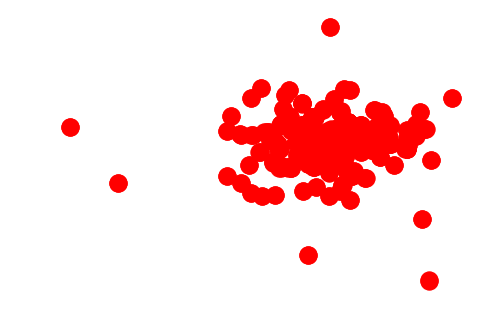

In [51]:
import matplotlib.pyplot as plt

G_Align=nx.Graph()
elist = unique_xmap
G_Align.add_weighted_edges_from(elist)
nx.draw(G_Align)
plt.show()

## compare node and edge connectivity
## compute largest connected component

In [52]:
print('Aligned graph have ',G_Align.number_of_nodes(),' nodes.')
print('Aligned graph have ',G_Align.number_of_edges(),' edges.')

Aligned graph have  1062  nodes.
Aligned graph have  2788  edges.


In [53]:
print('Target graph have ',G_target_na.number_of_nodes(),' nodes.')
print('Target graph have ',G_target_na.number_of_edges(), ' edges.')

Target graph have  1072  nodes.
Target graph have  3338  edges.


In [54]:
sum_weight=0
for i in range(len(unique_xmap)):
    sum_weight=sum_weight+ unique_xmap[i][2]
total_weight=0    
for i in range(len(nd1)):
    for j in range(len(nd2)):
        temp=G_target_na.get_edge_data(str(nd1[i]),str(nd2[j]))
        if(temp!=None):
            total_weight=total_weight+int(list(temp.values())[0])
print('Maximum Weight in Aligned graph: ',sum_weight) 
print('Total Weight in Target: ',total_weight)

Maximum Weight in Aligned graph:  323545
Total Weight in Target:  365195


In [55]:
# returns number of different connected components 
print('number of different connected components in Aligned graph: ',nx.number_connected_components(G_Align)) 
print('number of different connected components in Target graph: ',nx.number_connected_components(G_target_na))  

number of different connected components in Aligned graph:  112
number of different connected components in Target graph:  112


In [56]:
# returns list of nodes in different connected components 
cc_align=list(nx.connected_components(G_Align))
cc_target=list(nx.connected_components(G_target_na))
print(list(nx.connected_components(G_Align))) 
print(list(nx.connected_components(G_target_na)))

[{'sc4742', 'mm17221', 'sc4387', 'mm16191', 'sc5026', 'mm11396', 'mm13853', 'sc3985', 'sc4679', 'sc4925', 'sc4934', 'sc4604', 'sc4763', 'mm17581', 'sc4850', 'sc4857', 'mm17071', 'sc4619', 'mm18269', 'sc5027', 'sc5006', 'mm18220', 'sc3672', 'sc4737', 'sc4621', 'sc4924', 'sc4748', 'mm18649', 'sc2630', 'sc3388', 'sc4527', 'sc5009', 'sc4171', 'sc4744', 'sc4498', 'mm18233', 'sc3599', 'sc2443', 'sc4921', 'sc4590', 'sc4618', 'mm17603', 'sc4676', 'sc3814'}, {'sc1921', 'mm9646', 'sc2186', 'sc4193', 'sc1093'}, {'sc3997', 'mm1305', 'sc1863', 'sc1443', 'sc3321', 'sc659', 'sc171', 'sc3521', 'mm1347', 'mm14346', 'sc1581', 'sc885', 'sc3223', 'sc2234', 'sc694', 'sc1071', 'mm3821', 'sc357', 'sc1458', 'mm1612', 'sc527', 'mm2153', 'sc842', 'sc2321', 'sc292', 'sc260', 'sc2507', 'sc670', 'mm3944', 'sc2247', 'mm6384', 'mm1953', 'sc3102', 'sc2533', 'mm2301', 'sc4019', 'sc785', 'sc3945', 'mm6851', 'sc3027', 'sc848', 'sc731', 'sc372', 'mm1051', 'mm2398', 'sc2735', 'sc146', 'sc2127', 'mm665', 'sc3922', 'sc1271'

In [57]:
# returns number of nodes to be removed 
# so that Graph becomes disconnected 
print(nx.node_connectivity(G_Align)) 
print(nx.node_connectivity(G_target_na))
# returns number of edges to be removed 
# so that Graph becomes disconnected 
print(nx.edge_connectivity(G_Align))
print(nx.edge_connectivity(G_target_na))

0
0
0
0


## check similarity of connected components

In [58]:
count=0
for i in range(len(cc_align)):
    for j in range(len(cc_target)):
        if(cc_align[i]==cc_target[j]):
            count=count+1
print(count)

109


In [59]:
Gc = max(nx.connected_component_subgraphs(G_Align), key=len)
print('Largest common connected graph in Aligned graph: ',len(Gc))
Gct = max(nx.connected_component_subgraphs(G_target_na), key=len)
print('Largest common connected graph in Target graph: ',len(Gct))

Largest common connected graph in Aligned graph:  309
Largest common connected graph in Target graph:  317


### check for mistake align

In [60]:
for i in range(len(unique_xmap)):
    if (G_target_na.has_edge(unique_xmap[i][0], unique_xmap[i][1])==False):
        print(unique_xmap[i])
        print(i)
print('no exist error')    

no exist error


# Compute Global Criteria Percents

In [61]:
# total ec
total_ec=G_target_na.number_of_edges()/G1.number_of_edges()*100
ratio_ec=score_ec_temp/total_ec*100
print("total EC: ",total_ec)
print("Percent of EC: ",ratio_ec)
print("EC:",ratio_ec/100)

total EC:  189.6590909090909
Percent of EC:  83.52306770521271
EC: 0.8352306770521271


In [62]:
# total ics
total_ics=G_target_na.number_of_edges()/count_induced*100
ratio_ics=score_ics_temp/total_ics*100
print("total ICS: ",total_ics)
print("Percent of ICS: ",ratio_ics)
print("ICS:", ratio_ics/100)

total ICS:  52.07488299531982
Percent of ICS:  83.5230677052127
ICS: 0.835230677052127


In [63]:
# total s3
total_s3=(G_target_na.number_of_edges()/(G1.number_of_edges()+count_induced-G_target_na.number_of_edges()))*100
ratio_s3=score_s3_temp/total_s3*100
print("total S3: ",total_s3)
print("Percent of S3: ",ratio_s3)
print("S3:",ratio_s3/100)

total S3:  69.08112582781457
Percent of S3:  74.98763715191153
S3: 0.7498763715191152


# compute FC

In [64]:
tree=[[unique_xmap[i][0],unique_xmap[i][1]] for i in range(len(unique_xmap))]
tree

[['mm18233', 'sc4748'],
 ['mm9646', 'sc1093'],
 ['mm6374', 'sc1128'],
 ['mm14063', 'sc1892'],
 ['mm1347', 'sc143'],
 ['mm5895', 'sc905'],
 ['mm17581', 'sc4498'],
 ['mm14262', 'sc4019'],
 ['mm3362', 'sc2834'],
 ['mm2895', 'sc2193'],
 ['mm22533', 'sc6160'],
 ['mm6119', 'sc3895'],
 ['mm504', 'sc48'],
 ['mm8780', 'sc1166'],
 ['mm4686', 'sc106'],
 ['mm8967', 'sc2060'],
 ['mm2454', 'sc118'],
 ['mm592', 'sc106'],
 ['mm6549', 'sc2193'],
 ['mm17603', 'sc4621'],
 ['mm6374', 'sc527'],
 ['mm14262', 'sc3027'],
 ['mm18233', 'sc4921'],
 ['mm5042', 'sc2577'],
 ['mm478', 'sc1253'],
 ['mm11476', 'sc2378'],
 ['mm592', 'sc2206'],
 ['mm6456', 'sc2960'],
 ['mm3362', 'sc486'],
 ['mm14022', 'sc6343'],
 ['mm4895', 'sc3541'],
 ['mm5693', 'sc5004'],
 ['mm603', 'sc260'],
 ['mm17644', 'sc1377'],
 ['mm18220', 'sc3985'],
 ['mm6549', 'sc2735'],
 ['mm1150', 'sc2363'],
 ['mm3821', 'sc400'],
 ['mm11666', 'sc3102'],
 ['mm5895', 'sc627'],
 ['mm4649', 'sc1231'],
 ['mm806', 'sc205'],
 ['mm18233', 'sc3672'],
 ['mm1150', 'sc3

# load ontology and create DAG graph

In [65]:
import pandas as pd
f=open('go.dag.obo.txt').readlines()
df=pd.DataFrame(f)
df

,0
0,GO:0046431 GO:0019599\n
1,GO:0046430 GO:0019595\n
2,GO:0046432 GO:0019361\n
3,GO:0034198 GO:0060733\n
4,GO:0046343 GO:0019872\n
5,GO:0034193 GO:0034195\n
6,GO:0034192 GO:0034194\n
7,GO:0034190 GO:0034191\n
8,GO:0046437 GO:0030632 GO:0070179\n
9,GO:0046340 GO:0046342\n


In [66]:
# preprocessing
dag_list=[]
for i in range(len(df[0])):
    m1=str(df[0][i])
    m1=m1.replace('GO:','')
    m1=m1.replace('\n','')
    s=m1.split(' ')
    dag_list.append(s)
dag_list

[['0046431', '0019599'],
 ['0046430', '0019595'],
 ['0046432', '0019361'],
 ['0034198', '0060733'],
 ['0046343', '0019872'],
 ['0034193', '0034195'],
 ['0034192', '0034194'],
 ['0034190', '0034191'],
 ['0046437', '0030632', '0070179'],
 ['0046340', '0046342'],
 ['0030852', '0045658', '0030853', '0045643', '0030854', '0045640'],
 ['0030853', '0045659', '0045644', '0045641'],
 ['0030851', '0030221', '0030223', '0030222'],
 ['0030856',
  '0003339',
  '0030860',
  '0045601',
  '0030857',
  '0072182',
  '0030858',
  '0045616'],
 ['0030857', '0045602', '0030861', '0045617', '0072183'],
 ['0030854', '0045645', '0045642', '0045660'],
 ['0030855',
  '0030859',
  '0030216',
  '0072192',
  '0060671',
  '0072160',
  '0060742',
  '0035026',
  '0072311',
  '0060487',
  '0045446',
  '0060644',
  '0002065'],
 ['0030858', '0045603', '0030862', '0045618'],
 ['0030859', '0045198'],
 ['0031106', '0032186'],
 ['0031105', '0032151', '0032152'],
 ['0031103', '0014814', '0048673', '0014012'],
 ['0031102', '00

In [67]:
dag_nd=[]
for i in range(len(dag_list)):
    for j in range(len(dag_list[i])):
        dag_nd.append(dag_list[i][j])
dag_nodes=set(dag_nd)
print(dag_nodes)
print(len(dag_nodes))

{'0043949', '0075212', '0023022', '0090195', '0032035', '0030228', '0000418', '0042001', '0009877', '0016713', '0007366', '0006857', '0048807', '0048803', '0045114', '0051141', '0009838', '0043834', '0002417', '0021662', '0018749', '0034167', '0008202', '0051262', '0015558', '0010466', '0004139', '0003037', '0032380', '0004351', '0006405', '0031625', '0043410', '0050805', '0047132', '0051050', '0000910', '0030217', '0018802', '0015864', '0045683', '0008071', '0044318', '0004800', '0018544', '0031502', '0070248', '0030120', '0047552', '0070996', '0048882', '0002460', '0034800', '0042847', '0015473', '0045136', '0008385', '0007414', '0070761', '0022878', '0044024', '0021888', '0031823', '0004856', '0006886', '0032668', '0015739', '0010577', '0042294', '0080099', '0050988', '0032478', '0002223', '0009132', '0042581', '0000278', '0032382', '0043147', '0060996', '0006963', '0031537', '0060736', '0021957', '0018123', '0042598', '0019446', '0090144', '0030790', '0008754', '0034586', '0071383'

In [68]:
# create dag edges
dag_edges=[]
for i in range(len(dag_list)):
    for j in range(1,len(dag_list[i])):
        ed=[dag_list[i][0],dag_list[i][j]]
        dag_edges.append(ed)
dag_edges

[['0046431', '0019599'],
 ['0046430', '0019595'],
 ['0046432', '0019361'],
 ['0034198', '0060733'],
 ['0046343', '0019872'],
 ['0034193', '0034195'],
 ['0034192', '0034194'],
 ['0034190', '0034191'],
 ['0046437', '0030632'],
 ['0046437', '0070179'],
 ['0046340', '0046342'],
 ['0030852', '0045658'],
 ['0030852', '0030853'],
 ['0030852', '0045643'],
 ['0030852', '0030854'],
 ['0030852', '0045640'],
 ['0030853', '0045659'],
 ['0030853', '0045644'],
 ['0030853', '0045641'],
 ['0030851', '0030221'],
 ['0030851', '0030223'],
 ['0030851', '0030222'],
 ['0030856', '0003339'],
 ['0030856', '0030860'],
 ['0030856', '0045601'],
 ['0030856', '0030857'],
 ['0030856', '0072182'],
 ['0030856', '0030858'],
 ['0030856', '0045616'],
 ['0030857', '0045602'],
 ['0030857', '0030861'],
 ['0030857', '0045617'],
 ['0030857', '0072183'],
 ['0030854', '0045645'],
 ['0030854', '0045642'],
 ['0030854', '0045660'],
 ['0030855', '0030859'],
 ['0030855', '0030216'],
 ['0030855', '0072192'],
 ['0030855', '0060671'],


In [69]:
import networkx as nx
go=nx.DiGraph()
go.add_nodes_from(dag_nodes)
go.add_edges_from(dag_edges)
go

In [70]:
# To unify the data, we need to delete the two letters of annotations and replace zero to achieve string with 7 lengths.
## According to species, these letters are different.
c=0
import numpy as np
na=tree
for i in range(len(tree)):
    for j in range(2):
        if ('mm' in tree[i][j] or 'sc' in tree[i][j]):
            s=tree[i][j][2:]
            x='0'*(7-len(s))
            y=x+s
            #print(y)
            na[i][j]=y
            c=c+1
print(len(tree),c)
print(len(na))

2788 5576
2788


In [71]:
fc=[]
for i in range(len(na)):
    if na[i][0] in dag_nodes:
        e=go.predecessors(na[i][0])
        if na[i][1] in dag_nodes: 
            f=go.predecessors(na[i][1])
            temp=[]
            for key in e:
                temp.append(key)
            for key in f:
                temp.append(key)
            # compute intersection/union 
            fc.append(sum([temp.count(temp[z])/len(temp) for z in range(len(temp))]))
        else:
            fc.append(0)
#print(fc)
# compute average of all fc 
func=np.average(fc)
print('functional coherence:',func)

functional coherence: 0.6311953352769679
